<a href="https://colab.research.google.com/github/pavel195/Django/blob/master/%D0%9A%D1%83%D1%80%D1%81%D0%B0%D1%87_%D0%A7%D0%B8%D0%BF%D0%BA%D0%B8%D0%BD%D0%B5%D0%B5%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install snscrape

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 927.7 kB/s eta 0:00:00


In [3]:
!pip install pymorphy2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 75.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=b41519d7a48152a34d0a5737761f0c0f044d816ede039bc328c4181b17cedb4b
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [4]:
import pandas as pd
import re
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pymorphy2
from nltk.tokenize import word_tokenize
from nltk.tokenize.casual import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from tensorflow.keras.utils import to_categorical
from sklearn.tree import plot_tree
import snscrape.modules.telegram as telegram
import nltk
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import log_loss

nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
# Парсер
def parsing(channel, channel_name, limit=2000):
  posts = []

  for i, post in enumerate(telegram.TelegramChannelScraper(channel).get_items()):
      if i >= limit:
          break
      post_data = {
          'post': post.content,
          'channel_name': channel_name
        }
      posts.append(post_data)
  return posts

# Каналы
# https://t.me/DtRoad - Транспорт Москвы
# https://t.me/transportspb -  Транспорт Санкт-Петербурга
# https://t.me/anrbc - Автомобильный транспорт
# https://t.me/morflot_gov - Водный транспорт


# Парсинг данных с каналов
moscow = parsing('DtRoad', 'Транспорт Москвы')
spb = parsing('transportspb', 'Транспорт Санкт-Петербурга')
auto = parsing('anrbc', 'Автомобильный транспорт')
water = parsing('morflot_gov', 'Водный транспорт')


# Формирование данных
df_moscow = pd.DataFrame(moscow, columns=['post', 'channel_name'])
df_spb = pd.DataFrame(spb, columns=['post', 'channel_name'])
df_auto = pd.DataFrame(auto, columns=['post', 'channel_name'])
df_water = pd.DataFrame(water, columns=['post', 'channel_name'])

In [6]:
# Очищаем от пустых постов (без текста) и от постов-дубликатов
def cleaner(df, channel_name):
    print('----------------------------------------')

    print(f'Результаты до чистки для канала "{channel_name}":')
    print(f'Размерность — {df.shape}')
    print(f'Нулевых строк: {df.isnull().sum()}')
    df = df[df['post'].str.strip().astype(bool)]
    print(f'Дубликатов: {df.duplicated().sum()}')


    df = df.drop_duplicates()
    duplicates = df.duplicated().sum()


    print()
    print()
    print('Результаты после чистки')
    print(f'Размерность — {df.shape}')
    print(f'Дубликатов: {duplicates}')
    print(f'Нулевых строк: {df.isnull().sum()}')

    print('----------------------------------------')
    return df


# Чистка датасетов с постами
df_moscow = cleaner(df_moscow, 'Транспорт Москвы')
df_spb = cleaner(df_spb, 'Транспорт Санкт-Петербурга')
df_auto = cleaner(df_auto, 'Автомобильный транспорт')
df_water = cleaner(df_water, 'Водный транспорт')

----------------------------------------
Результаты до чистки для канала "Транспорт Москвы":
Размерность — (2000, 2)
Нулевых строк: post            259
channel_name      0
dtype: int64
Дубликатов: 23


Результаты после чистки
Размерность — (1718, 2)
Дубликатов: 0
Нулевых строк: post            0
channel_name    0
dtype: int64
----------------------------------------
----------------------------------------
Результаты до чистки для канала "Транспорт Санкт-Петербурга":
Размерность — (2000, 2)
Нулевых строк: post            20
channel_name     0
dtype: int64
Дубликатов: 174


Результаты после чистки
Размерность — (1806, 2)
Дубликатов: 0
Нулевых строк: post            0
channel_name    0
dtype: int64
----------------------------------------
----------------------------------------
Результаты до чистки для канала "Автомобильный транспорт":
Размерность — (2000, 2)
Нулевых строк: post            132
channel_name      0
dtype: int64
Дубликатов: 2


Результаты после чистки
Размерность — (1862, 

In [7]:
# Формируем единый датасет на основе датасета с минимальным количеством постов относительно всех, чтобы убрать дизбаланс классов
min_posts = min(df_moscow.shape[0], df_spb.shape[0], df_auto.shape[0], df_water.shape[0]) // 100 * 100

df = pd.concat([df_moscow.head(min_posts), df_spb.head(min_posts), df_auto.head(min_posts), df_water.head(min_posts)], ignore_index=True)
df

,post,channel_name
0,Готовы узнать о самых необычных мотоциклах ССС...,Транспорт Москвы
1,Отлично провели День России на площадках Транс...,Транспорт Москвы
2,ЦОДД: в городе местами идет дождь — соблюдайте...,Транспорт Москвы
3,🚝 Показали эволюцию «Иволг» — самых современны...,Транспорт Москвы
4,В День России отдыхаем с пользой для смекалки ...,Транспорт Москвы
...,...,...
5595,В г. Перми прошел первый «Всероссийский круизн...,Водный транспорт
5596,Погода помогла перевести работу всех паромов н...,Водный транспорт
5597,Росморречфлот 18 октября 2022 г. с 12:00 мск о...,Водный транспорт
5598,С начала работы Керченской паромной переправы ...,Водный транспорт


In [8]:
le = LabelEncoder()

# применение LabelEncoder к столбцу channel_name
df['channel_id'] = le.fit_transform(df['channel_name'])
df

,post,channel_name,channel_id
0,Готовы узнать о самых необычных мотоциклах ССС...,Транспорт Москвы,2
1,Отлично провели День России на площадках Транс...,Транспорт Москвы,2
2,ЦОДД: в городе местами идет дождь — соблюдайте...,Транспорт Москвы,2
3,🚝 Показали эволюцию «Иволг» — самых современны...,Транспорт Москвы,2
4,В День России отдыхаем с пользой для смекалки ...,Транспорт Москвы,2
...,...,...,...
5595,В г. Перми прошел первый «Всероссийский круизн...,Водный транспорт,1
5596,Погода помогла перевести работу всех паромов н...,Водный транспорт,1
5597,Росморречфлот 18 октября 2022 г. с 12:00 мск о...,Водный транспорт,1
5598,С начала работы Керченской паромной переправы ...,Водный транспорт,1


In [9]:
df_subset = df[['channel_name', 'channel_id']]

# удаляем дубликаты по столбцам channel_name и channel_id
df_unique = df_subset.drop_duplicates(subset=['channel_name', 'channel_id'])

# уникальные значения
df_unique

,channel_name,channel_id
0,Транспорт Москвы,2
1400,Транспорт Санкт-Петербурга,3
2800,Автомобильный транспорт,0
4200,Водный транспорт,1


In [10]:
decoder_dict = df_unique.set_index('channel_id')['channel_name'].to_dict()

decoder_dict

{2: 'Транспорт Москвы',
 3: 'Транспорт Санкт-Петербурга',
 0: 'Автомобильный транспорт',
 1: 'Водный транспорт'}

channel_name
Транспорт Москвы              1400
Транспорт Санкт-Петербурга    1400
Автомобильный транспорт       1400
Водный транспорт              1400
Name: count, dtype: int64


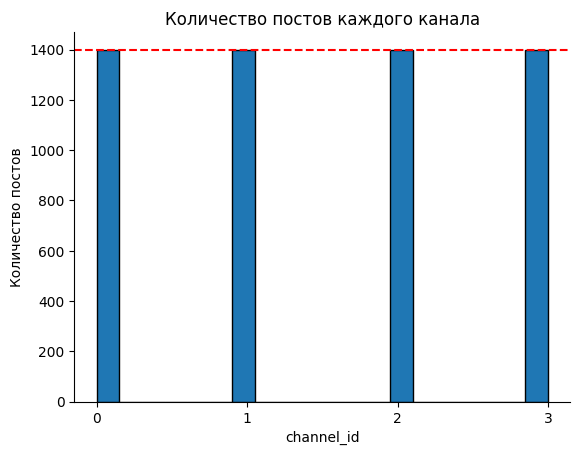

In [11]:
# Визуализируем баланс классов для наглядности
plt.hist(df['channel_id'], bins=20, edgecolor='black')
plt.title('Количество постов каждого канала')
plt.xlabel('channel_id')
plt.ylabel('Количество постов')
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.xticks(range(4))

# добавляем горизонтальную линию, которая означает максимум по количеству значений оси y
y_max = df['channel_id'].value_counts().max()
plt.axhline(y=y_max, color='r', linestyle='--');

print(df['channel_name'].value_counts())

In [12]:
# Функция удаления эмодзи
def emojis(text):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # Emoticons
        u"\U0001F300-\U0001F5FF"  # Symbols & Pictographs
        u"\U0001F680-\U0001F6FF"  # Transport & Map Symbols
        u"\U0001F700-\U0001F77F"  # Alchemical Symbols
        u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
        u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
        u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        u"\U0001FA00-\U0001FA6F"  # Chess Symbols
        u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        u"\U00002702-\U000027B0"  # Dingbats
        u"\U000024C2-\U0001F251"  # Enclosed Characters
        u"0-9"                    # Digits
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# Функция удаления спец символов
def spec_chars(text):
    special_chars = re.compile(
        r"[–—!\"#$%&()«»“”*+,\-./:;<=>?@[\]^_`{|}~\t\n\xa0–\ufeff']")
    return special_chars.sub(r'', text)

# Обработка постов: лемматизация, токенизация, удаление стоп-слов, эмодзи, цифр, пробелов, спец-символов; приводим к нижнему регистру
def processing(df):
    stop_words = stopwords.words('russian')
    morph = pymorphy2.MorphAnalyzer()
    lemmatizer = WordNetLemmatizer()
    tknzr = TweetTokenizer()
    tokenize_document = []

    df_posts = df.astype({'post': str})
    for document in df_posts['post']:
        document = emojis(document)
        document = tknzr.tokenize(document)
        document = [word.lower() for word in document]
        document = [spec_chars(word) for word in document]
        document = [word for word in document if word not in stop_words]
        document = [word for word in document if word]
        document = [lemmatizer.lemmatize(word) for word in document]
        document = [morph.normal_forms(word)[0] for word in document]
        tokenize_document.append(document)



    return tokenize_document

tokenized_document = processing(df)
texts = [' '.join(i) for i in tokenized_document]
df['clear_texts'] = texts
texts

['готовый узнать самый необычный мотоцикл ссср честь всемирный день мотоциклист посвятить выпуск музейный среда интересный история директор музей транспорт москва оксана бондаренко рассказать мотоцикл кремлёвский гараж мотоциклахвездеход интересный',
 'отлично провести день россия площадка транспортный комплекс вместе вы делиться впечатление рассказывать это северный речной вокзал состояться грандиозный флешмоб человек выстроиться парадный лестница цвет триколор выступить участник всероссийский молодёжный фестиваль духов оркестр ты страна музыкальный коллектив домисолька желать отправить поздравление близкие открытка почта россия посмотреть фильм открытый кинотеатр станция таганский артист детский хор преображение исполнить патриотический песня гимн российский федерация станция курский пассажир услышать выступление оркестр центральный округ войско национальный гвардия российский федерация спасибо вместе мы поддерживать традиция атмосфера праздник желать приятный поездка dtroad',
 'цодд

In [13]:
df_grouped = df.groupby('channel_id')

In [14]:
def wordscloud(df, channel_id):
    df = df_grouped.get_group(channel_id)

    text = ' '.join(df['clear_texts'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud)

    plt.title(f'Облако слов для канала "{decoder_dict[channel_id]}"')
    plt.axis('off')

    plt.show()
    plt.close()

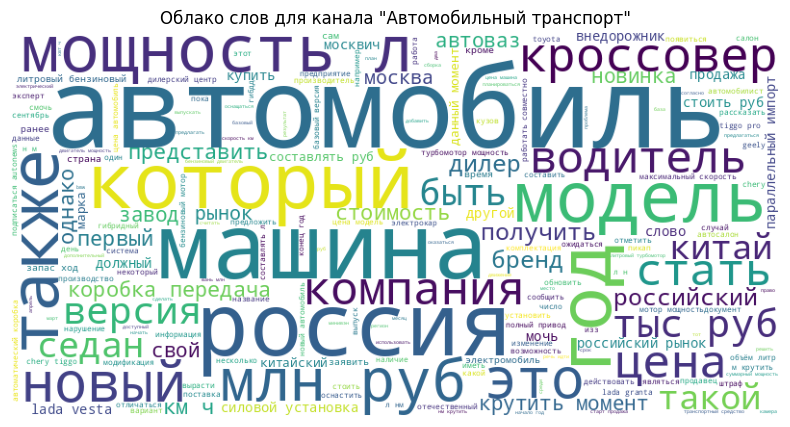

In [15]:
wordscloud(df_grouped, 0)

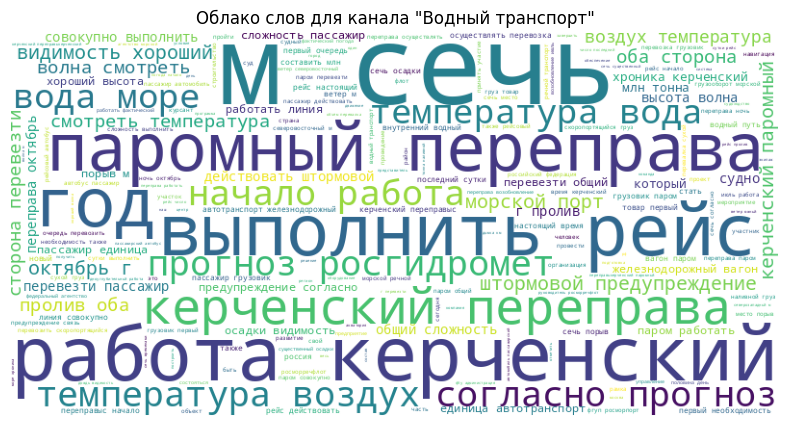

In [16]:
wordscloud(df_grouped, 1)

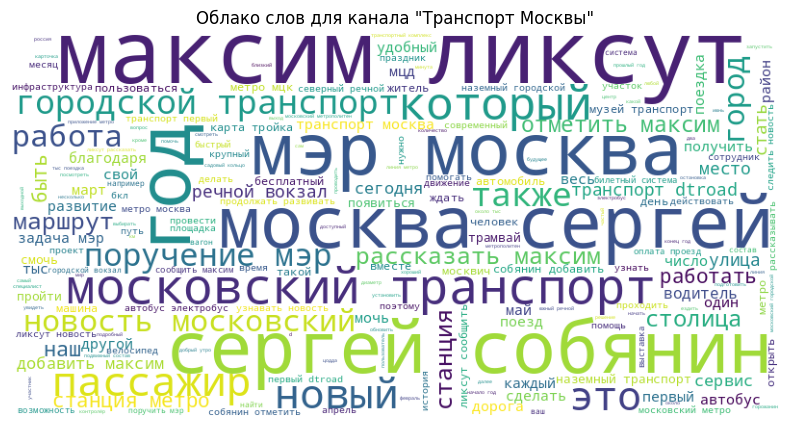

In [17]:
wordscloud(df_grouped, 2)

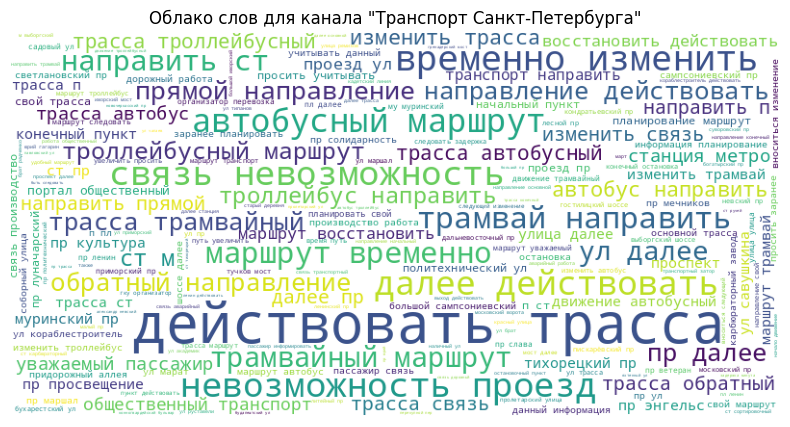

In [18]:
wordscloud(df_grouped, 3)

In [19]:
def vectorizing(text):
    vectorizer = TfidfVectorizer(max_features=10000)
    X = vectorizer.fit_transform(text)
    return X, vectorizer

In [20]:
X, vectorizer = vectorizing(df['clear_texts'])
y = df['channel_id']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'Размерность X_train: {X_train.shape}')
print(f'Размерность X_test: {X_test.shape}')
print(f'Размерность y_train: {y_train.shape}')
print(f'Размерность y_test: {y_test.shape}')

Размерность X_train: (4480, 10000)
Размерность X_test: (1120, 10000)
Размерность y_train: (4480,)
Размерность y_test: (1120,)


In [46]:
print(X)

[[    0     0     0 ...  1128 11104   601]
 [    0     0     0 ...  1860    59   192]
 [    0     0     0 ...  2659  4462  1415]
 ...
 [    0     0     0 ...   126  1202   161]
 [    0     0     0 ...    82    74  2916]
 [    0     0     0 ...   317   758  1349]]


In [49]:
print(vectorizer.vocabulary_)

{'готовый': 2302, 'узнать': 9068, 'самый': 7791, 'необычный': 4814, 'мотоцикл': 4470, 'ссср': 8382, 'честь': 9623, 'всемирный': 1889, 'день': 2502, 'мотоциклист': 4472, 'посвятить': 6463, 'выпуск': 2008, 'музейный': 4506, 'среда': 8364, 'интересный': 3307, 'история': 3386, 'директор': 2570, 'музей': 4504, 'транспорт': 8821, 'москва': 4442, 'оксана': 5227, 'бондаренко': 1283, 'рассказать': 7406, 'кремлёвский': 3822, 'гараж': 2113, 'отлично': 5506, 'провести': 6947, 'россия': 7656, 'площадка': 6018, 'транспортный': 8826, 'комплекс': 3636, 'вместе': 1647, 'вы': 1938, 'делиться': 2490, 'впечатление': 1853, 'рассказывать': 7407, 'это': 9905, 'северный': 7890, 'речной': 7570, 'вокзал': 1769, 'состояться': 8260, 'грандиозный': 2315, 'флешмоб': 9350, 'человек': 9600, 'выстроиться': 2056, 'парадный': 5661, 'лестница': 4000, 'цвет': 9534, 'триколор': 8866, 'выступить': 2058, 'участник': 9239, 'всероссийский': 1891, 'молодёжный': 4419, 'фестиваль': 9304, 'духов': 2737, 'оркестр': 5352, 'ты': 8942

In [21]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.4 MB/s eta 0:00:00


[I 2024-06-12 18:59:14,343] A new study created in memory with name: no-name-dbada62d-16a8-4085-be97-a9ee7f043972
[I 2024-06-12 18:59:30,837] Trial 0 finished with value: 0.96875 and parameters: {'n_estimators': 881, 'max_depth': 26, 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'criterion': 'gini'}. Best is trial 0 with value: 0.96875.
[I 2024-06-12 18:59:38,342] Trial 1 finished with value: 0.9508928571428571 and parameters: {'n_estimators': 575, 'max_depth': 45, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 0 with value: 0.96875.
[I 2024-06-12 18:59:45,109] Trial 2 finished with value: 0.9508928571428571 and parameters: {'n_estimators': 612, 'max_depth': 37, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 0 with value: 0.96875.
[I 2024-06-12 18:59:51,546] Trial 3 finished with value: 0.9455357142857143 and parameters: {'n_estimators': 472,

Best trial:
  Value: 0.9767857142857143
  Params: 
    n_estimators: 400
    max_depth: 46
    min_samples_split: 8
    min_samples_leaf: 2
    max_features: sqrt
    criterion: entropy
Accuracy: 0.9768


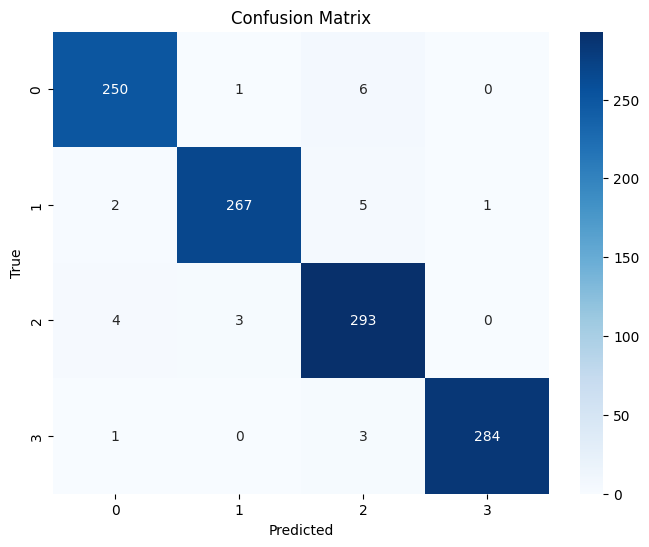

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       257
           1       0.99      0.97      0.98       275
           2       0.95      0.98      0.97       300
           3       1.00      0.99      0.99       288

    accuracy                           0.98      1120
   macro avg       0.98      0.98      0.98      1120
weighted avg       0.98      0.98      0.98      1120



In [22]:
import optuna

def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 4, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy'])
    }

    model = RandomForestClassifier(**param, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Запуск оптимизации
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print('Best trial:')
trial = study.best_trial
print(f'  Value: {trial.value}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

# Получение лучших параметров
best_params = trial.params

# Создание модели с лучшими параметрами
model_forest = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features'],
    criterion=best_params['criterion'],
    random_state=42
)

# Обучение модели
model_forest.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = model_forest.predict(X_test)

# Оценка точности
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Матрица ошибок
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Подробный отчет по классификации
report = classification_report(y_test, y_pred)
print(report)

In [50]:
# Вычисление метрик
forest_accuracy = accuracy_score(y_test, y_pred)
forest_precision = precision_score(y_test, y_pred, average='weighted')
forest_recall = recall_score(y_test, y_pred, average='weighted')
forest_f1 = f1_score(y_test, y_pred, average='weighted')

# Вывод результатов
print(f'Accuracy: {forest_accuracy:.4f}')
print(f'Precision: {forest_precision:.4f}')
print(f'Recall: {forest_recall:.4f}')
print(f'F1-score: {forest_f1:.4f}')

ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets

In [24]:
models_metrics = {} # Словарь с метриками моделей для дальнейшего их сравнения

In [25]:
models_metrics['RandomForest'] = {'accuracy': forest_accuracy, 'precision': forest_precision ,'recall': forest_recall, 'f1-score': forest_f1}

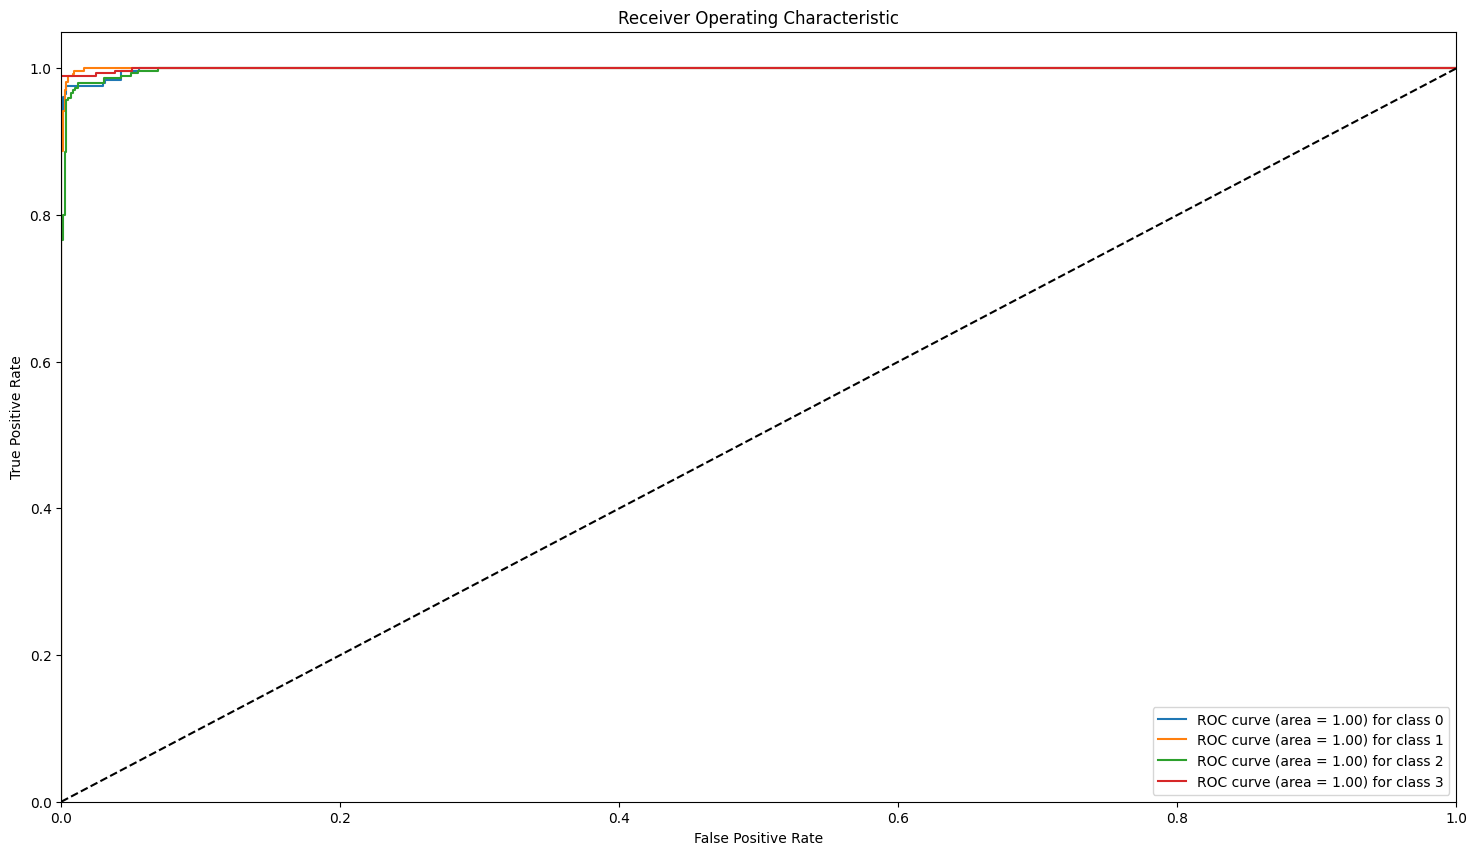

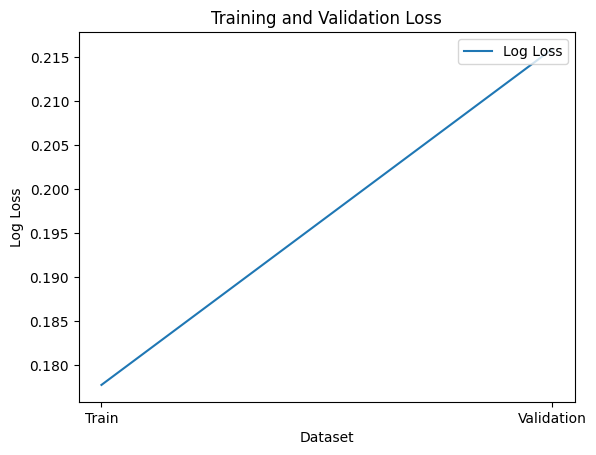

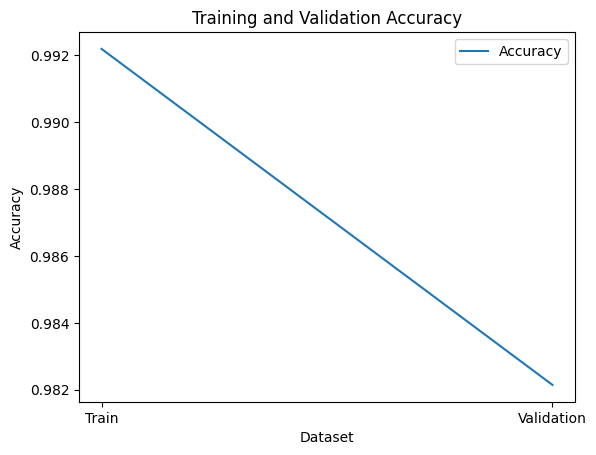

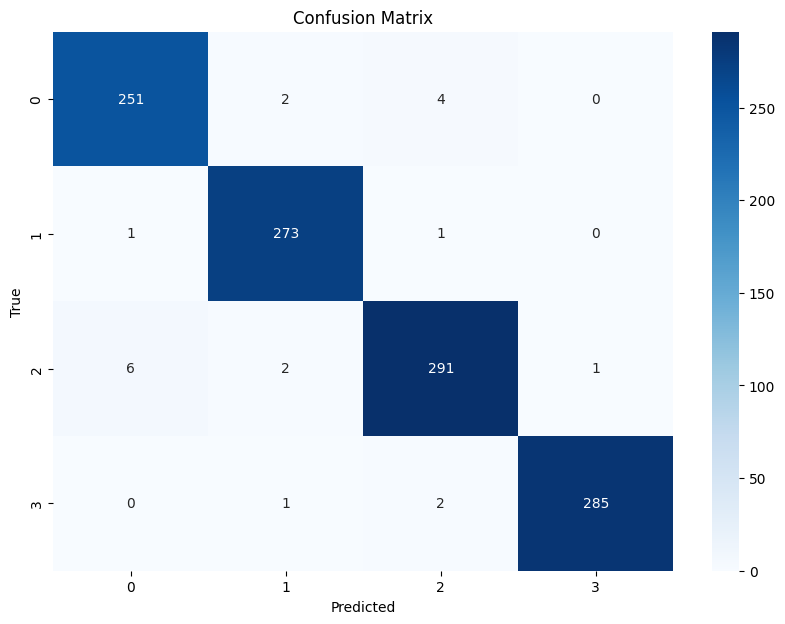

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       257
           1       0.98      0.99      0.99       275
           2       0.98      0.97      0.97       300
           3       1.00      0.99      0.99       288

    accuracy                           0.98      1120
   macro avg       0.98      0.98      0.98      1120
weighted avg       0.98      0.98      0.98      1120

Training Accuracy: 0.9921875
Validation Accuracy: 0.9821428571428571


In [26]:
model_logreg = OneVsRestClassifier(LogisticRegression(max_iter=1000))
model_logreg.fit(X_train, y_train)

y_train_pred = model_logreg.predict(X_train)
y_test_pred = model_logreg.predict(X_test)

# ROC Curve
y_test_bin = label_binarize(y_test, classes=np.unique(y))
y_test_pred_prob = model_logreg.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(np.unique(y))):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(18, 10))
for i in range(len(np.unique(y))):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:0.2f}) for class {i}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate log loss
train_loss = log_loss(y_train, model_logreg.predict_proba(X_train))
test_loss = log_loss(y_test, model_logreg.predict_proba(X_test))

# Training and Validation Loss
plt.figure()
plt.plot([1, 2], [train_loss, test_loss], label='Log Loss')
plt.xticks([1, 2], ['Train', 'Validation'])
plt.xlabel('Dataset')
plt.ylabel('Log Loss')
plt.title('Training and Validation Loss')
plt.legend(loc="upper right")
plt.show()

# Training and Validation Accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

plt.figure()
plt.plot([1, 2], [train_accuracy, test_accuracy], label='Accuracy')
plt.xticks([1, 2], ['Train', 'Validation'])
plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc="upper right")
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_test_pred))
print('Training Accuracy:', train_accuracy)
print('Validation Accuracy:', test_accuracy)


In [27]:
logreg_accuracy = accuracy_score(y_test, y_test_pred)
logreg_precision = precision_score(y_test, y_test_pred, average='weighted')
logreg_recall = recall_score(y_test, y_test_pred, average='weighted')
logreg_f1 = f1_score(y_test, y_test_pred, average='weighted')


print(f'Accuracy: {logreg_accuracy:.4f}')
print(f'F1-score: {logreg_precision:.4f}')
print(f'Recall: {logreg_recall:.4f}')
print(f'Precision: {logreg_f1:.4f}')

Accuracy: 0.9821
F1-score: 0.9822
Recall: 0.9821
Precision: 0.9821


In [28]:
models_metrics['LogisticRegressiong'] = {'accuracy': logreg_accuracy, 'precision': logreg_precision, 'recall': logreg_recall, 'f1-score': logreg_f1}

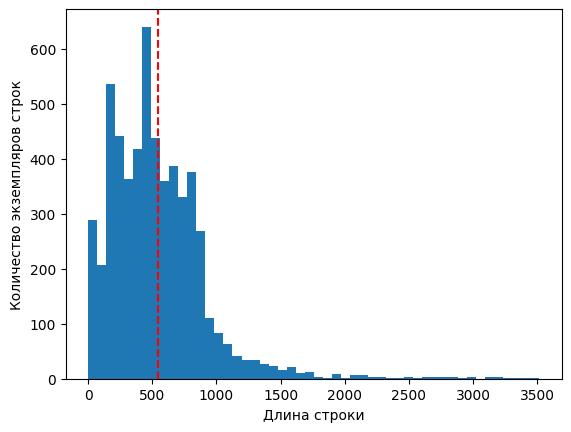



Средняя длина постов: 540.0 слов


In [29]:
# создаем гистограмму распределения длины строк
average = df['clear_texts'].apply(len).mean()


plt.hist(df['clear_texts'].apply(len), bins=50)
plt.xlabel('Длина строки')
plt.ylabel('Количество экземпляров строк')
plt.axvline(x=average, color='r', linestyle='--')
plt.show()


avg_str_len = average // 10 * 10
print()
print()

print(f'Средняя длина постов: {avg_str_len} слов' ) # будет ораничение для паддинга

In [30]:

# Преобразование целевой переменной в категориальные метки
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['channel_id'])
y = to_categorical(y)  # Преобразование в формат one-hot encoding

# Токенизация текста
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['clear_texts'])
sequences = tokenizer.texts_to_sequences(df['clear_texts'])

# Паддинг последовательностей для обеспечения одинаковой длины
max_sequence_length = int(avg_str_len)  # Максимальная длина последовательностей
X = pad_sequences(sequences, maxlen=max_sequence_length)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Определение параметров модели
vocab_size = len(tokenizer.word_index) + 1  # Размер словаря (количество уникальных слов)
embedding_dim = 100  # Размерность векторного представления слов

# Создание модели
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(units=4, activation='softmax'))  # Количество классов 4

# Компиляция модели
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Обучение модели
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

# Оценка модели на тестовой выборке
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy:.4f}')

Epoch 1/10
56/56 [==============================] - 128s 2s/step - loss: 0.8979 - accuracy: 0.6950 - val_loss: 0.3821 - val_accuracy: 0.9129
Epoch 2/10
56/56 [==============================] - 102s 2s/step - loss: 0.1882 - accuracy: 0.9581 - val_loss: 0.0975 - val_accuracy: 0.9710
Epoch 3/10
56/56 [==============================] - 99s 2s/step - loss: 0.0427 - accuracy: 0.9911 - val_loss: 0.1089 - val_accuracy: 0.9688
Epoch 4/10
56/56 [==============================] - 99s 2s/step - loss: 0.0968 - accuracy: 0.9757 - val_loss: 0.1569 - val_accuracy: 0.9565
Epoch 5/10
56/56 [==============================] - 101s 2s/step - loss: 0.0389 - accuracy: 0.9936 - val_loss: 0.0899 - val_accuracy: 0.9754
Epoch 6/10
56/56 [==============================] - 98s 2s/step - loss: 0.0145 - accuracy: 0.9975 - val_loss: 0.0850 - val_accuracy: 0.9766
Epoch 7/10
56/56 [==============================] - 109s 2s/step - loss: 0.0093 - accuracy: 0.9983 - val_loss: 0.0814 - val_accuracy: 0.9788
Epoch 8/10
56/56

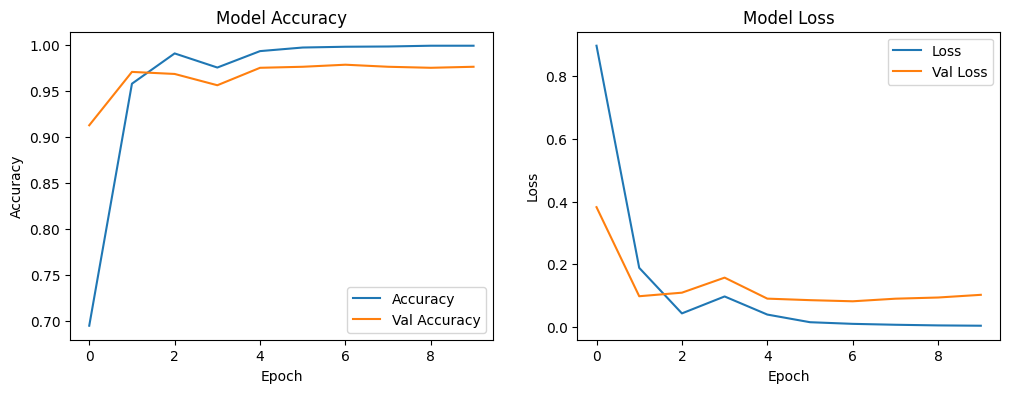

35/35 [==============================] - 10s 269ms/step


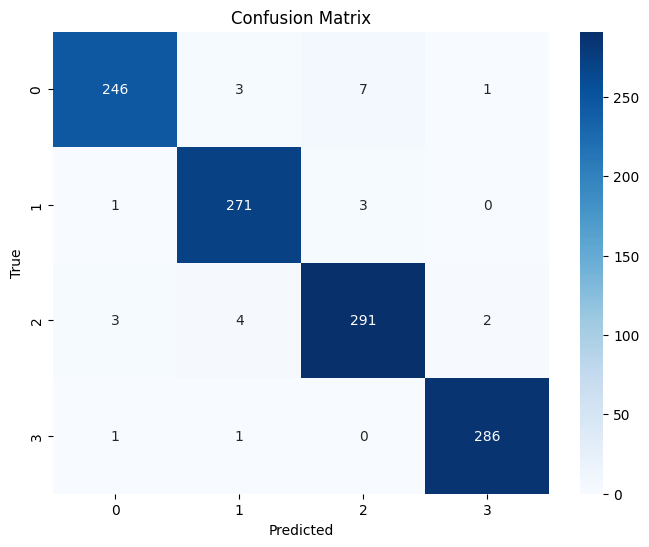

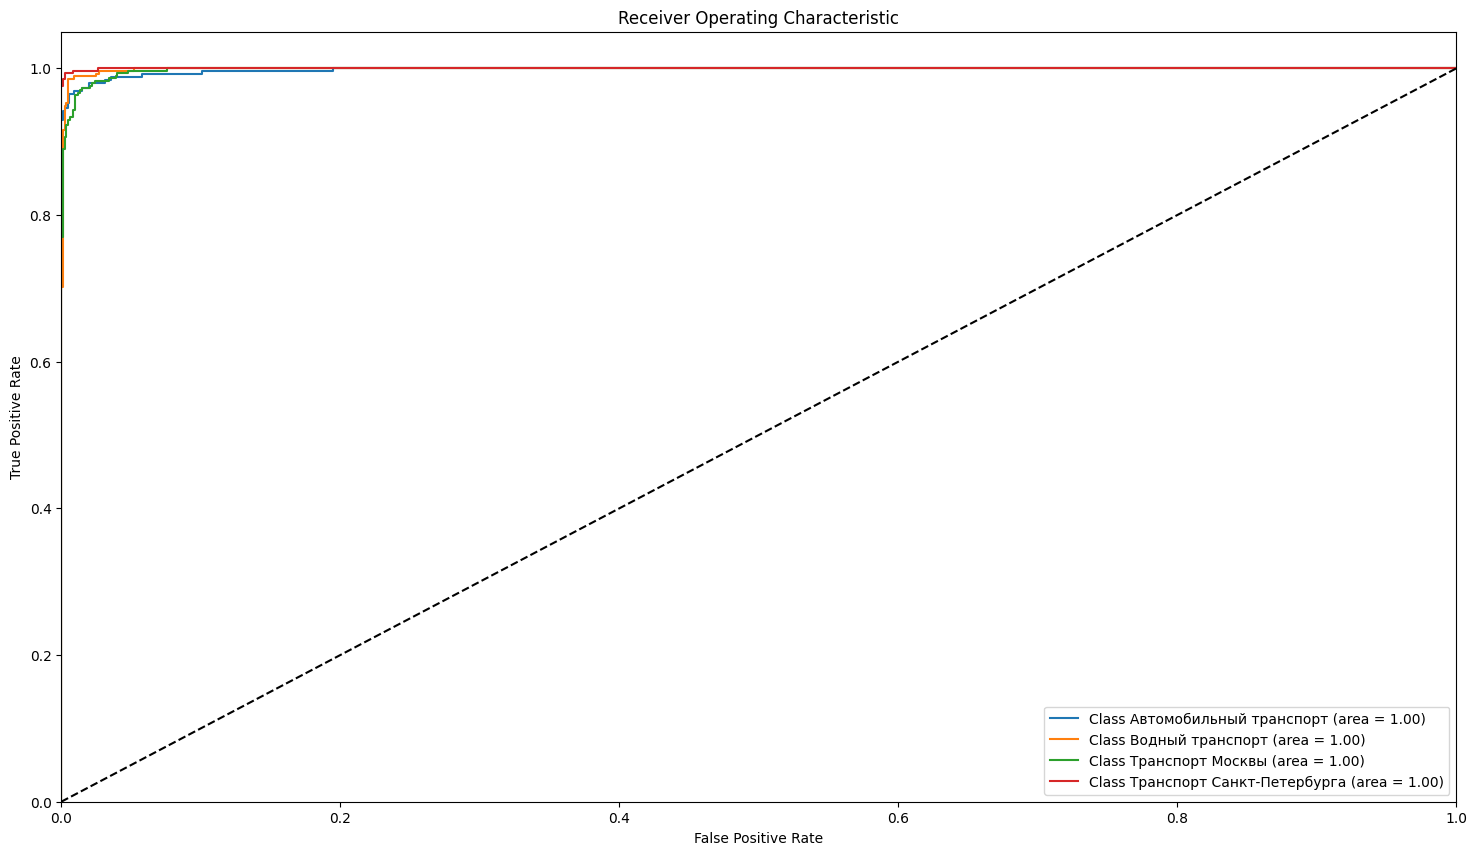

In [31]:
# Визуализация истории обучения
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Предсказания на тестовых данных
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Матрица ошибок
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC-кривые и AUC для каждого класса
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(y.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Визуализация ROC-кривых
plt.figure(figsize=(18, 10))
for i in range(y.shape[1]):
    plt.plot(fpr[i], tpr[i], label=f'Class {decoder_dict[i]} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [33]:
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

In [51]:
y_pred

array([[3.87760112e-04, 9.99235272e-01, 8.91900127e-05, 2.87790550e-04],
       [1.08955814e-04, 9.99643207e-01, 9.10218369e-05, 1.56778508e-04],
       [6.18269405e-06, 2.07856574e-05, 5.23205163e-05, 9.99920666e-01],
       ...,
       [7.02152087e-04, 9.97072279e-01, 7.83220574e-04, 1.44241273e-03],
       [9.99775410e-01, 4.39443465e-05, 4.54175351e-05, 1.35216324e-04],
       [9.99559343e-01, 8.05371237e-05, 1.20176905e-04, 2.39818852e-04]],
      dtype=float32)

In [52]:
y_pred_classes

array([1, 1, 3, ..., 1, 0, 0])

In [35]:
# Вычисление метрик

emb_accuracy = accuracy_score(y_test_classes, y_pred_classes)
emb_precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
emb_recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
emb_f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')

# Вывод результатов
print(f'Accuracy: {emb_accuracy:.4f}')
print(f'Precision: {emb_precision:.4f}')
print(f'Recall: {emb_recall:.4f}')
print(f'F1-score: {emb_f1:.4f}')

Accuracy: 0.9768
Precision: 0.9768
Recall: 0.9768
F1-score: 0.9768


In [36]:
models_metrics['Neuron'] = {'accuracy': emb_accuracy, 'precision': emb_precision, 'recall': emb_recall, 'f1-score': emb_f1}

In [37]:
from tabulate import tabulate


models_metrics_copy = models_metrics.copy()
# Преобразование словаря в список списков для tabulate
data = [(model, *metrics.values()) for model, metrics in models_metrics_copy.items()]

# Форматирование и вывод таблички
print(tabulate(data, headers=['Model\Metrics', 'Accuracy', 'Precision', 'Recall', 'F1 Score'], tablefmt='grid'))

+---------------------+------------+-------------+----------+------------+
| Model\Metrics       |   Accuracy |   Precision |   Recall |   F1 Score |
+=====================+============+=============+==========+============+
| RandomForest        |   0.976786 |    0.977009 | 0.976786 |   0.976843 |
+---------------------+------------+-------------+----------+------------+
| LogisticRegressiong |   0.982143 |    0.982167 | 0.982143 |   0.982141 |
+---------------------+------------+-------------+----------+------------+
| Embedding           |   0.976786 |    0.97682  | 0.976786 |   0.976758 |
+---------------------+------------+-------------+----------+------------+


In [38]:
df_stats_0 = pd.DataFrame(models_metrics_copy).T

# Функция для возвращения цвета в зависимости от значения
def highlight_min_max(s):
    is_max = s == s.max()
    is_min = s == s.min()
    styles = ['background-color: red' if v else '' for v in is_max]
    styles = ['background-color: green' if v else styles[i] for i, v in enumerate(is_min)]
    return styles

# Применение функции форматирования к DataFrame
styled_df = df_stats_0.style.apply(highlight_min_max)

# Вывод таблички
styled_df

,accuracy,precision,recall,f1-score
RandomForest,0.976786,0.977009,0.976786,0.976843
LogisticRegressiong,0.982143,0.982167,0.982143,0.982141
Embedding,0.976786,0.976820,0.976786,0.976758


In [54]:
def predict_new_post(model, vectorizer, new_post, threshold=0.7):

    stop_words = stopwords.words('russian')
    morph = pymorphy2.MorphAnalyzer()
    lemmatizer = WordNetLemmatizer()
    tknzr = TweetTokenizer()


    new_post = emojis(new_post)
    new_post = tknzr.tokenize(new_post)
    new_post = [word.lower() for word in new_post]
    new_post = [spec_chars(word) for word in new_post]
    new_post = [word for word in new_post if word not in stop_words]
    new_post = [word for word in new_post if word]
    new_post = [lemmatizer.lemmatize(word) for word in new_post]
    new_post = [morph.normal_forms(word)[0] for word in new_post]
    new_post_text = ' '.join(new_post)
    new_post_vector = vectorizer.transform([new_post_text])

    # Предсказание моделью
    pred_prob = model.predict_proba(new_post_vector)
    print(pred_prob)
    # Нахождение максимального значения вероятности
    max_prob = max(pred_prob[0])

    # Проверка, превышает ли максимальное значение вероятности порог доверия
    if max_prob > threshold:
        # Нахождение индекса канала с максимальной вероятностью
        channel_index = np.argmax(pred_prob[0])
        # Возврат индекса канала
        print(max_prob)
        return channel_index
    else:
        print(max_prob)
        # Возврат сообщения об ошибке
        return "Пост не подходит ни для одного канала"



In [55]:
new_post = """
Ми-8 со спасателями совершил вынужденную посадку в Якутии.

Сегодня утром (по якутскому времени) вертолет Ми-8 (RA-25477) «Полярных авиалиний» выполнял облет лесного массива по маршруту Саскылах — Саскылах. В Якутии сейчас тушат лесные пожары на площади свыше 7,7 тыс. гектаров. На борту воздушного судна находились три члена экипажа, два техника и семь спасателей.

В районе десяти утра от МЧС поступила информация о том, что вертолет совершил аварийную посадку из-за неисправности. Но установить связь с экипажем и уточнить характер неисправности не получалось. Только спустя час пилоты сами позвонили по телефону и сообщили, что совершили вынужденную посадку в 50 км севернее аэропорта Саскылах по причине подтекания масла, уточнив, что никто не пострадал, а борт повреждений не получил.

На данный момент пилоты ожидают прибытия другого Ми-8, на котором им доставят масло для устранения неисправности.
"""
predicted_channel = predict_new_post(model_logreg, vectorizer, new_post)

if predicted_channel in [0,1,2,3]:
     print('Прогнозируемый канал:', decoder_dict[predicted_channel])
else:
     print('Прогнозируемый канал:', predicted_channel)

[[0.28184014 0.34875464 0.29760153 0.07180369]]
0.3487546386067488
Прогнозируемый канал: Пост не подходит ни для одного канала


In [56]:
new_post = """
В связи с невозможностью проезда по Автобусной ул. у Маршала Новикова трассы автобусных маршрутов №№ 40, 127, 127М временно изменены.

Автобусные маршруты №№ 40, 127, 127М направлены: от Автобусного парка№ 2 по Автобусной ул., Ново-Никитинской ул., Шуваловскому пр., Парашютной ул., Долгоозерной ул., далее по действующим трассам.
"""
predicted_channel = predict_new_post(model_logreg, vectorizer, new_post)

if predicted_channel in [0,1,2,3]:
     print('Прогнозируемый канал:', decoder_dict[predicted_channel])
else:
     print('Прогнозируемый канал:', predicted_channel)

[[0.00823458 0.0065482  0.00599214 0.97922508]]
0.9792250813026797
Прогнозируемый канал: Транспорт Санкт-Петербурга


In [58]:
new_post = """
Voyah назвал цену (https://www.autonews.ru/news/666811ca9a794718c24f016f) на кроссовер Free в версии Sport Edition. Автомобиль отличается от обычных версий более агрессивным дизайном экстерьера, а также некоторыми улучшениями в салоне.

Спортивный Free комплектуется двумя электромоторами и ДВС объемом 1,5 литра, который напрямую не связан с колесами. Пиковая суммарная отдача агрегатов составляет 490 л.с. С места до «сотни» гибрид разгоняется за 4,8 секунды, а автономный пробег заявлен на уровне 1000 км.

Согласно прайс-листу на сайте производителя, автомобиль доступен за 6 490 000 руб. без учета скидок.
"""
predicted_channel = predict_new_post(model_logreg, vectorizer, new_post)

if predicted_channel in [0,1,2,3]:
     print('Прогнозируемый канал:', decoder_dict[predicted_channel])
else:
     print('Прогнозируемый канал:', predicted_channel)

[[0.90476266 0.0393704  0.03346654 0.0224004 ]]
0.9047626614710975
Прогнозируемый канал: Автомобильный транспорт


In [59]:
new_post = """
В рамках #ПМЭФ2024 руководитель Росморречфлота Андрей Тарасенко провел встречу (https://morflot.gov.ru/novosti/lenta/rukovoditel-rosmorrechflota-i-glava-dnr-obsudili-voprosy-razvitiya-mariupol-skogo-morskogo-torgovogo-porta/) с Главой Донецкой Народной Республики Денисом Пушилиным, на которой обсудили вопросы возобновления полноценного функционирования Мариупольского морского торгового порта и возможности для увеличения грузооборота.

🔵Одной из первых задач по развитию портовой инфраструктуры является определение номенклатуры грузов.

🔵Рассматривается вопрос выделения квот на поступление абитуриентов из ДНР в отраслевые учебные заведения Росморречфлота.
"""
predicted_channel = predict_new_post(model_logreg, vectorizer, new_post)

if predicted_channel in [0,1,2,3]:
     print('Прогнозируемый канал:', decoder_dict[predicted_channel])
else:
     print('Прогнозируемый канал:', predicted_channel)

[[0.07415728 0.85871766 0.04685696 0.0202681 ]]
0.858717663228809
Прогнозируемый канал: Водный транспорт


In [61]:
new_post = """
 Напоминаем, что 12 июня оставить авто на улицах Москвы можно будет бесплатно.

Парковки со шлагбаумом продолжат работать по обычным тарифам.

«По решению Мэра Москвы Сергея Собянина (https://t.me/mos_sobyanin/11067) в честь Дня России уличные парковки в столице станут бесплатными. Это не повлияет на загруженность дорог и улиц, потому что в городе будет меньше автомобилей. Поздравляем с наступающим праздником и просим водителей соблюдать правила остановки и стоянки для безопасности всех участников дорожного движения», — отметил Максим Ликсутов.
"""
predicted_channel = predict_new_post(model_logreg, vectorizer, new_post)

if predicted_channel in [0,1,2,3]:
     print('Прогнозируемый канал:', decoder_dict[predicted_channel])
else:
     print('Прогнозируемый канал:', predicted_channel)

[[0.05449249 0.00946773 0.90191925 0.03412052]]
0.9019192501122243
Прогнозируемый канал: Транспорт Москвы
